In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re

import nltk
import re
import string

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss

from tqdm import tqdm
tqdm.pandas() 

import gensim
from gensim.parsing.porter import PorterStemmer

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Activation, GlobalAveragePooling1D, GlobalMaxPool1D, Input, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200) 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
# reading the train, test, and validation dataset (train.tsv is a tab separated values, hence we use sep='\t')

train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')
val_df = pd.read_csv('dev.tsv', sep='\t')

train_df.head()

,text,label,.
0,My favourite food is anything I didn't have to cook myself.,27,eebbqej
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [51]:
test_df.head()

,text,label,.
0,"I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!",25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be an interesting game to watch!",13,een27c3
3,"I didn't know that, thank you for teaching me something today!",15,eelgwd1
4,They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.,27,eem5uti


In [52]:
val_df.head()

,text,label,.
0,Is this in New Orleans?? I really feel like this is New Orleans.,27,edgurhb
1,"You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,"The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today","4,27",edc32e2
4,He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.,20,eepig6r


In [53]:
train_df = train_df.rename(columns={0: "text", 1: "label", 2: "."})
test_df = test_df.rename(columns={0: "text", 1: "label", 2: "."})
val_df = val_df.rename(columns={0: "text", 1: "label", 2: "."})

In [54]:
# dropping unnecessary column

train_df = train_df.drop(columns=".")
test_df = test_df.drop(columns=".")
val_df = val_df.drop(columns=".")

In [55]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(43410, 2)
(5427, 2)
(5426, 2)


In [56]:
# dropping missing values and duplicates

train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
val_df = val_df.drop_duplicates()

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(43297, 2)
(5422, 2)
(5424, 2)


In [57]:
train_df.head(10)

,text,label
0,My favourite food is anything I didn't have to cook myself.,27
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,26
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,15
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"8,20"
8,Damn youtube and outrage drama is super lucrative for reddit,0
9,It might be linked to the trust factor of your friend.,27


In [58]:
# converting labels into list

train_df['classes'] =  train_df['label'].apply(lambda x: [int(classes) for classes in x.split(",")])
test_df['classes'] =  test_df['label'].apply(lambda x: [int(classes) for classes in x.split(",")])
val_df['classes'] =  val_df['label'].apply(lambda x: [int(classes) for classes in x.split(",")])

In [59]:
train_df.head(10)

,text,label,classes
0,My favourite food is anything I didn't have to cook myself.,27,[27]
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,[27]
2,WHY THE FUCK IS BAYLESS ISOING,2,[2]
3,To make her feel threatened,14,[14]
4,Dirty Southern Wankers,3,[3]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,26,[26]
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,15,[15]
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"8,20","[8, 20]"
8,Damn youtube and outrage drama is super lucrative for reddit,0,[0]
9,It might be linked to the trust factor of your friend.,27,[27]


In [60]:
# creating a list to convert the numeric values into emotion strings

emotions = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral"
]

def convert_labels(label_nums):
    return [emotions[i] for i in label_nums]

# convert numeric labels to emotion strings
train_df['classes'] = train_df['classes'].apply(lambda x: convert_labels(x))
test_df['classes'] = test_df['classes'].apply(lambda x: convert_labels(x))
val_df['classes'] = val_df['classes'].apply(lambda x: convert_labels(x))

In [61]:
train_df.head(10)

,text,label,classes
0,My favourite food is anything I didn't have to cook myself.,27,[neutral]
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,[anger]
3,To make her feel threatened,14,[fear]
4,Dirty Southern Wankers,3,[annoyance]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,26,[surprise]
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,15,[gratitude]
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"8,20","[desire, optimism]"
8,Damn youtube and outrage drama is super lucrative for reddit,0,[admiration]
9,It might be linked to the trust factor of your friend.,27,[neutral]


In [62]:
print('Number of emotions: ', len(emotions))

Number of emotions:  28


In [63]:
# grouping similar emotions into one emotion
emotions_group = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness"],
    "joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
    "surprise": ["surprise", "realization", "confusion", "curiosity"],
    "neutral": ['neutral']
}

def map_emotions(emotions):
    mapped_categories = set()
    for emotion in emotions:
        for category, subcategories in emotions_group.items():
            if emotion in subcategories:
                mapped_categories.add(category)
    
    return list(mapped_categories)

# Apply the mapping to create a new column
train_df['grouped_classes'] = train_df['classes'].apply(map_emotions)
test_df['grouped_classes'] = test_df['classes'].apply(map_emotions)
val_df['grouped_classes'] = val_df['classes'].apply(map_emotions)

In [64]:
train_df.head(20)

,text,label,classes,grouped_classes
0,My favourite food is anything I didn't have to cook myself.,27,[neutral],[neutral]
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,[anger],[anger]
3,To make her feel threatened,14,[fear],[fear]
4,Dirty Southern Wankers,3,[annoyance],[anger]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,26,[surprise],[surprise]
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,15,[gratitude],[joy]
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"8,20","[desire, optimism]",[joy]
8,Damn youtube and outrage drama is super lucrative for reddit,0,[admiration],[joy]
9,It might be linked to the trust factor of your friend.,27,[neutral],[neutral]


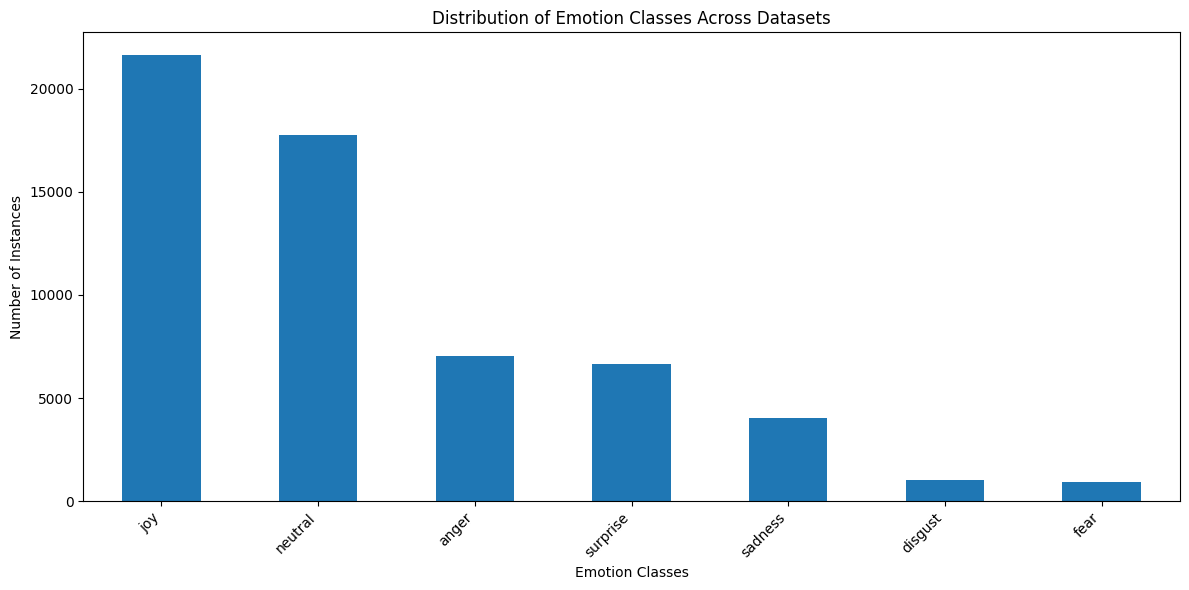

Train Dataset Emotion Counts:
joy         17335
neutral     14193
anger        5575
surprise     5362
sadness      3260
disgust       792
fear          726
Name: count, dtype: int64

Test Dataset Emotion Counts:
joy         2100
neutral     1786
anger        726
surprise     677
sadness      379
disgust      123
fear          98
Name: count, dtype: int64

Validation Dataset Emotion Counts:
joy         2217
neutral     1766
anger        717
surprise     624
sadness      390
fear         105
disgust       97
Name: count, dtype: int64


In [65]:
import matplotlib.pyplot as plt
import pandas as pd

def count_emotions(dfs):
    all_emotions = []
    for df in dfs:
        all_emotions.extend([emotion for emotions in df['grouped_classes'] for emotion in emotions])
    
    return pd.Series(all_emotions).value_counts()

# count emotions across train, test, and validation DataFrames
emotion_counts = count_emotions([train_df, test_df, val_df])

plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotion Classes Across Datasets')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Train Dataset Emotion Counts:")
print(count_emotions([train_df]))
print("\nTest Dataset Emotion Counts:")
print(count_emotions([test_df]))
print("\nValidation Dataset Emotion Counts:")
print(count_emotions([val_df]))

In [66]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = ["joy", "neutral", "anger", "surprise", "sadness", "disgust", "fear"]
label_counts = [17335, 14193, 5575, 5362, 3260, 792, 726]

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(labels)),  # Integer indices for labels
    y=np.concatenate([
        np.full(count, i) for i, count in enumerate(label_counts)
    ])
)

# Convert to dictionary format
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)


Class weights: {0: 0.3893279492356504, 1: 0.4755160994856619, 2: 1.2105829596412556, 3: 1.2586721372622156, 4: 2.070245398773006, 5: 8.521464646464647, 6: 9.296143250688706}


In [67]:
# dropping label and classes column

train_df = train_df.drop(columns=['label', 'classes'])
test_df = test_df.drop(columns=['label', 'classes'])
val_df = val_df.drop(columns=['label', 'classes'])

In [68]:
# convert list to string for one-hot encoding
train_df['grouped_classes'] = train_df['grouped_classes'].apply(lambda x: ','.join(x))
test_df['grouped_classes'] = test_df['grouped_classes'].apply(lambda x: ','.join(x))
val_df['grouped_classes'] = val_df['grouped_classes'].apply(lambda x: ','.join(x))


# one hot encoding
one_hot_train_df = train_df['grouped_classes'].str.get_dummies(sep=',')
one_hot_test_df = test_df['grouped_classes'].str.get_dummies(sep=',')
one_hot_val_df = val_df['grouped_classes'].str.get_dummies(sep=',')

train_df = pd.concat([train_df, one_hot_train_df], axis=1)
test_df = pd.concat([test_df, one_hot_test_df], axis=1)
val_df = pd.concat([val_df, one_hot_val_df], axis=1)

train_df = train_df.drop(columns=['grouped_classes'])
test_df = test_df.drop(columns=['grouped_classes'])
val_df = val_df.drop(columns=['grouped_classes'])

In [69]:
train_df.head(20)

,text,anger,disgust,fear,joy,neutral,sadness,surprise
0,My favourite food is anything I didn't have to cook myself.,0,0,0,0,1,0,0
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",0,0,0,0,1,0,0
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0
3,To make her feel threatened,0,0,1,0,0,0,0
4,Dirty Southern Wankers,1,0,0,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,0,0,0,0,0,0,1
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,0,0,0,1,0,0,0
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,0,0,0,1,0,0,0
8,Damn youtube and outrage drama is super lucrative for reddit,0,0,0,1,0,0,0
9,It might be linked to the trust factor of your friend.,0,0,0,0,1,0,0


In [70]:
train_df.to_csv('newTrain.csv', index=False)
test_df.to_csv('newTest.csv', index=False)
val_df.to_csv('newVal.csv', index=False)

In [71]:
train_df = pd.read_csv('newTrain.csv')
test_df = pd.read_csv('newTest.csv')
val_df = pd.read_csv('newVal.csv')

In [72]:
train_df.head(20)

# Text anomalies:
# 1. Words surrounded by brackets ([NAME], [RELIGION], etc)
# 2. Words that start with slash (/jk, /e)
# 3. Reddit subreddits (r/AskReddit, r/relationships)

,text,anger,disgust,fear,joy,neutral,sadness,surprise
0,My favourite food is anything I didn't have to cook myself.,0,0,0,0,1,0,0
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",0,0,0,0,1,0,0
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0
3,To make her feel threatened,0,0,1,0,0,0,0
4,Dirty Southern Wankers,1,0,0,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,0,0,0,0,0,0,1
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,0,0,0,1,0,0,0
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,0,0,0,1,0,0,0
8,Damn youtube and outrage drama is super lucrative for reddit,0,0,0,1,0,0,0
9,It might be linked to the trust factor of your friend.,0,0,0,0,1,0,0


In [73]:
def lower_case(text):
    return text.lower()

def remove_brackets(text):
    return re.sub(r'\[.*?\]', '', text)

def remove_slash(text):
    return re.sub(r'\/[a-z]*', '', text)

def remove_subreddits(text):
    return re.sub(r'r/[a-zA-Z]*', '', text)

def remove_non_alphabets(text):
    return ''.join([char for char in text if char.isalpha() or char.isspace()])

def custom_preprocessing(text):
    text = lower_case(text)
    text = remove_brackets(text)
    text = remove_slash(text)
    text = remove_subreddits(text)
    return text

def preprocess_text(text, stop_words):
    text = custom_preprocessing(text)
    tokens = gensim.utils.simple_preprocess(text)
    
    # removing stopwords and em
    tokens = [i for i in tokens if i not in stop_words]
    return tokens


stop_words = set(nltk.corpus.stopwords.words('english'))

train_df['tokens'] = train_df['text'].progress_apply(preprocess_text, args=(stop_words,))
test_df['tokens'] = test_df['text'].progress_apply(preprocess_text, args=(stop_words,))
val_df['tokens'] = val_df['text'].progress_apply(preprocess_text, args=(stop_words,))

train_df.head()

100%|██████████| 5424/5424 [00:00<00:00, 76031.71it/s]


,text,anger,disgust,fear,joy,neutral,sadness,surprise,tokens
0,My favourite food is anything I didn't have to cook myself.,0,0,0,0,1,0,0,"[favourite, food, anything, cook]"
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",0,0,0,0,1,0,0,"[everyone, think, hes, laugh, screwing, people, instead, actually, dead]"
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0,"[fuck, bayless, isoing]"
3,To make her feel threatened,0,0,1,0,0,0,0,"[make, feel, threatened]"
4,Dirty Southern Wankers,1,0,0,0,0,0,0,"[dirty, southern, wankers]"


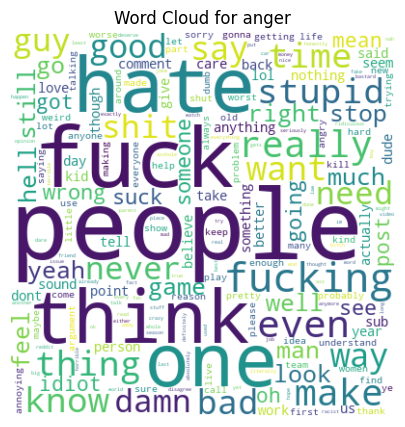

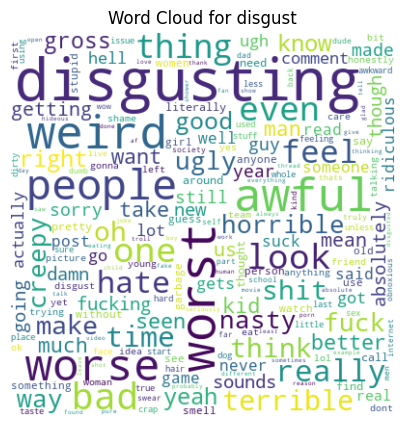

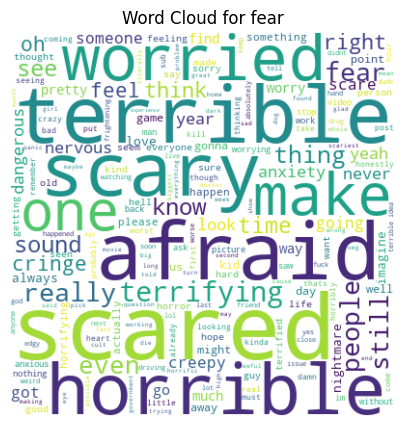

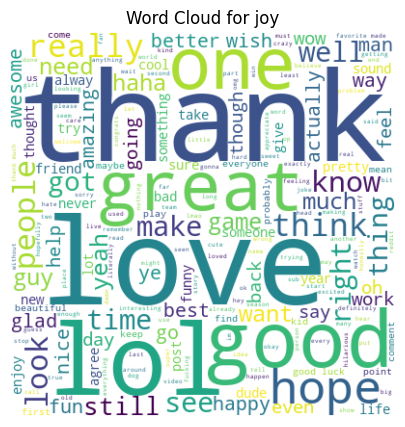

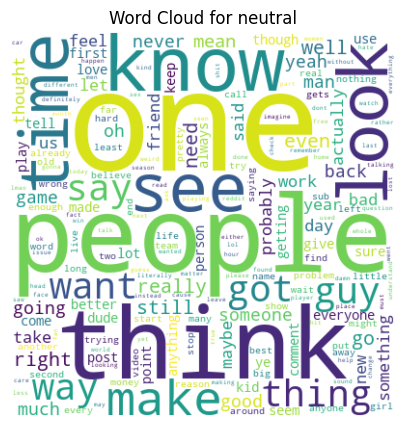

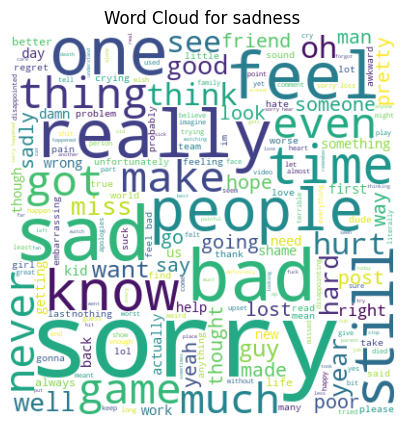

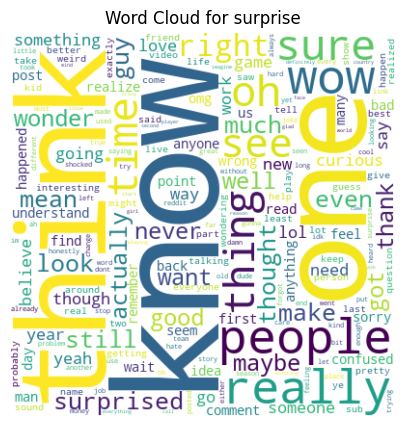

No text data available for tokens


In [74]:
def generate_wordcloud(text_data, class_name):
    # combining all text entries into a single string
    combined_text = ' '.join(text_data)
    
    if combined_text.strip():  # check if combined_text is not empty
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate(combined_text)
        
        # display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {class_name}")
        plt.show()
    else:
        print(f"No text data available for {class_name}")

for class_name in train_df.columns[1:]:
    class_text = train_df[train_df[class_name] == 1]['tokens'].apply(lambda x: ' '.join(x))
    generate_wordcloud(class_text, class_name)

For the anger wordcloud, some common words are "never", "fucking", "think", "people", and "hate".

The disgust wordcloud includes words like "awful", "worse", "disgusting", "nasty", and "weird".

The fear wordcloud features words such as "afraid", "scared", "scary", "horrible", and "terrible".

The joy wordcloud contains positive words like "good", "thank", "lol", "love", and "great".

For the neutral class wordcloud, contains a more general words without a emotional context like "people", "look", "know", "make", "one", and "time".

The sadness wordcloud contains sad words like "sorry", "sad", "bad", "really".

Finally, the surprise class wordcloud features words like "wow", "really", "wonder", and "know".

In [75]:
# joining each tokens into whole sentence

train_df['text'] = train_df['tokens'].apply(lambda x: ' '.join(x))
test_df['text'] = test_df['tokens'].apply(lambda x: ' '.join(x))
val_df['text'] = val_df['tokens'].apply(lambda x: ' '.join(x))

train_df = train_df.drop(columns=['tokens'])
test_df = test_df.drop(columns=['tokens'])
val_df = val_df.drop(columns=['tokens'])

train_df.head()

,text,anger,disgust,fear,joy,neutral,sadness,surprise
0,favourite food anything cook,0,0,0,0,1,0,0
1,everyone think hes laugh screwing people instead actually dead,0,0,0,0,1,0,0
2,fuck bayless isoing,1,0,0,0,0,0,0
3,make feel threatened,0,0,1,0,0,0,0
4,dirty southern wankers,1,0,0,0,0,0,0


In [ ]:
label_columns = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
train_df["labels"] = train_df[label_columns].values.tolist()
test_df["labels"] = test_df[label_columns].values.tolist()
val_df["labels"] = val_df[label_columns].values.tolist()

In [74]:
train_df.head()

,text,anger,disgust,fear,joy,neutral,sadness,surprise,labels
0,favourite food anything cook,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
1,everyone think hes laugh screwing people instead actually dead,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
2,fuck bayless isoing,1,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0]"
3,make feel threatened,0,0,1,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0]"
4,dirty southern wankers,1,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0]"


# DISTILBERT

In [75]:
import re
import html
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
from datasets import Dataset

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

In [76]:
dataset_train = Dataset.from_pandas(train_df)
dataset_val = Dataset.from_pandas(val_df)
dataset_test = Dataset.from_pandas(test_df)

In [77]:

# Define the model checkpoint and tokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

# Define the tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, return_tensors=None)

# Tokenize the training dataset (ensure it has a "text" column)
train_encoded = dataset_train.map(tokenize, batched=True)

# Calculate the length of each 'input_ids' sequence in the training dataset
input_ids_lengths = [len(input_ids) for input_ids in train_encoded["input_ids"]]

# Find the maximum length of the 'input_ids' sequences
max_input_ids_length = max(input_ids_lengths)
print(f"Maximum input IDs length: {max_input_ids_length}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/43297 [00:00<?, ? examples/s]

Maximum input IDs length: 35


In [78]:
# Define the tokenization function with a maximum sequence length
def tokenize_max_len(batch):
    return tokenizer(
        batch["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_input_ids_length
    )

# Tokenize the datasets in batches (train, validation, and test)
train_encoded = dataset_train.map(tokenize_max_len, batched=True)
val_encoded = dataset_val.map(tokenize_max_len, batched=True)
test_encoded = dataset_test.map(tokenize_max_len, batched=True)


Map:   0%|          | 0/43297 [00:00<?, ? examples/s]

Map:   0%|          | 0/5424 [00:00<?, ? examples/s]

Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

In [79]:
train_encoded

Dataset({
    features: ['text', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 43297
})

In [80]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# Parameters
batch_size = 32
learning_rate = 0.00001
epochs = 20
num_labels = 7

# Initialize the BERT model for multi-label classification
model = TFDistilBertForSequenceClassification.from_pretrained(
    model_ckpt,
    problem_type='multi_label_classification',
    num_labels=num_labels
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [81]:
import tf_keras

# Extract tokenizer input columns
tokenizer_columns = tokenizer.model_input_names

# Convert training dataset to TensorFlow format
tf_train_dataset = train_encoded.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols="labels",  # Ensure "labels" exists in the dataset
    shuffle=True,
    batch_size=batch_size
)

# Convert validation dataset to TensorFlow format
tf_eval_dataset = val_encoded.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols="labels",
    shuffle=False,
    batch_size=batch_size
)

# Define optimizer
optimizer = tf_keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=0.01)

early_stopping = tf_keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=2,  # Stop training after `patience` epochs with no improvement
    restore_best_weights=True,  # Restore the best model weights
)

def micro_f1(y_true, y_pred):
    # Round predictions to binary (0 or 1)
    y_pred = tf.round(tf.sigmoid(y_pred))
    
    # Flatten the labels and predictions
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Compute True Positives, False Positives, and False Negatives
    true_positives = tf.reduce_sum(y_true_flat * y_pred_flat)
    false_positives = tf.reduce_sum(y_pred_flat * (1 - y_true_flat))
    false_negatives = tf.reduce_sum((1 - y_pred_flat) * y_true_flat)
    
    # Compute Precision and Recall
    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
    
    # Compute F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1
    
def hamming_loss(y_true, y_pred):
    # Round predictions to binary (0 or 1)
    y_pred = tf.round(tf.sigmoid(y_pred))
    
    # Compute the Hamming loss
    incorrect = tf.not_equal(y_true, y_pred)
    hamming_loss = tf.reduce_mean(tf.cast(incorrect, tf.float32))
    
    return hamming_loss

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy", micro_f1, hamming_loss],
)


model.summary()


Model: "tf_distil_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_79 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66958855 (255.43 MB)
Trainable params: 66958855 (255.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Unpreprocessed Text with Distilbert

In [39]:
# Train the model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    batch_size=batch_size,
    callbacks=[early_stopping],
    epochs=epochs,
    class_weight=class_weights_dict
)

Epoch 1/20
1354/1354 [==============================] - 877s 631ms/step - loss: 0.6960 - accuracy: 0.6095 - micro_f1: 0.5429 - hamming_loss: 0.1102 - val_loss: 0.2252 - val_accuracy: 0.6657 - val_micro_f1: 0.6594 - val_hamming_loss: 0.0925
Epoch 2/20
1354/1354 [==============================] - 853s 630ms/step - loss: 0.5347 - accuracy: 0.6952 - micro_f1: 0.6890 - hamming_loss: 0.0880 - val_loss: 0.2140 - val_accuracy: 0.6820 - val_micro_f1: 0.6881 - val_hamming_loss: 0.0893
Epoch 3/20
1354/1354 [==============================] - 853s 630ms/step - loss: 0.4877 - accuracy: 0.7276 - micro_f1: 0.7251 - hamming_loss: 0.0795 - val_loss: 0.2163 - val_accuracy: 0.6829 - val_micro_f1: 0.6948 - val_hamming_loss: 0.0895
Epoch 4/20
1354/1354 [==============================] - 852s 630ms/step - loss: 0.4449 - accuracy: 0.7562 - micro_f1: 0.7583 - hamming_loss: 0.0710 - val_loss: 0.2230 - val_accuracy: 0.6787 - val_micro_f1: 0.6902 - val_hamming_loss: 0.0928


In [45]:
tf_test_dataset = test_encoded.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols="labels",
    shuffle=False,
    batch_size=batch_size
)

model.evaluate(tf_test_dataset)

170/170 [==============================] - 34s 202ms/step - loss: 0.2138 - accuracy: 0.6890 - micro_f1: 0.6854 - hamming_loss: 0.0897


[0.2138415426015854,
 0.6890446543693542,
 0.6853675246238708,
 0.08967961370944977]

## Preprocessed Text with Distilbert

In [82]:
# Train the model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    batch_size=batch_size,
    callbacks=[early_stopping],
    epochs=epochs,
    class_weight=class_weights_dict
)

Epoch 1/20
1354/1354 [==============================] - 139s 91ms/step - loss: 0.7727 - accuracy: 0.5596 - micro_f1: 0.4317 - hamming_loss: 0.1231 - val_loss: 0.2551 - val_accuracy: 0.6348 - val_micro_f1: 0.6091 - val_hamming_loss: 0.1041
Epoch 2/20
1354/1354 [==============================] - 118s 87ms/step - loss: 0.6269 - accuracy: 0.6513 - micro_f1: 0.6236 - hamming_loss: 0.1013 - val_loss: 0.2456 - val_accuracy: 0.6433 - val_micro_f1: 0.6269 - val_hamming_loss: 0.1017
Epoch 3/20
1354/1354 [==============================] - 118s 87ms/step - loss: 0.5874 - accuracy: 0.6734 - micro_f1: 0.6581 - hamming_loss: 0.0943 - val_loss: 0.2483 - val_accuracy: 0.6410 - val_micro_f1: 0.6259 - val_hamming_loss: 0.1028
Epoch 4/20
1354/1354 [==============================] - 118s 87ms/step - loss: 0.5465 - accuracy: 0.7016 - micro_f1: 0.6922 - hamming_loss: 0.0864 - val_loss: 0.2483 - val_accuracy: 0.6381 - val_micro_f1: 0.6300 - val_hamming_loss: 0.1032


In [83]:
tf_test_dataset = test_encoded.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols="labels",
    shuffle=False,
    batch_size=batch_size
)

model.evaluate(tf_test_dataset)

170/170 [==============================] - 5s 31ms/step - loss: 0.2499 - accuracy: 0.6405 - micro_f1: 0.6184 - hamming_loss: 0.1034


[0.2498568743467331,
 0.6405385732650757,
 0.6184297204017639,
 0.10341010242700577]

In [113]:
import numpy as np
import tensorflow as tf

def predict_labels(sentence, model, tokenizer, threshold=0.4):
    # Tokenize the input sentence
    inputs = tokenizer(
        sentence,
        padding="max_length",
        truncation=True,
        max_length=max_input_ids_length,
        return_tensors="tf"
    )
    
    # Get model outputs (logits)
    outputs = model(inputs)
    logits = outputs.logits
    
    # Apply sigmoid to get probabilities
    probabilities = tf.sigmoid(logits)
    
    # Convert to numpy array for easier processing
    probs = probabilities.numpy()[0]
    
    # Apply threshold to get predictions (1 for labels above threshold, 0 for others)
    predictions = (probs >= threshold).astype(int)
    
    # If all predictions are 0, select the label with the highest probability
    if np.sum(predictions) == 0:
        max_prob_index = np.argmax(probs)
        predictions[max_prob_index] = 1
    
    return predictions, probs

# Example sentence to predict
test_sentence = "I never thought it was at the same moment, but sometimes after [NAME] sacrifice... sounds logical"

# Call the prediction function
predictions, probabilities = predict_labels(test_sentence, model, tokenizer)

# Print the predictions and probabilities
print("\nPredictions:", predictions)
print("Probabilities:", probabilities)

# Emotion labels
emotion_labels = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]

# Display the predictions with corresponding labels and probabilities
print("\nMultilabel Predictions:")
print("-" * 50)
for label, pred, prob in zip(emotion_labels, predictions, probabilities):
    status = "✓" if pred == 1 else " "
    print(f"{label.capitalize():<10}: [{status}] Probability: {prob:.3f}")



Predictions: [0 0 0 0 1 0 1]
Probabilities: [0.03167407 0.00236555 0.0018415  0.10145161 0.57096076 0.01903538
 0.40658885]

Multilabel Predictions:
--------------------------------------------------
Anger     : [ ] Probability: 0.032
Disgust   : [ ] Probability: 0.002
Fear      : [ ] Probability: 0.002
Joy       : [ ] Probability: 0.101
Neutral   : [✓] Probability: 0.571
Sadness   : [ ] Probability: 0.019
Surprise  : [✓] Probability: 0.407


# Model From Scratch

In [76]:
# initailizing the tokenizer
tokenizer = Tokenizer(num_words=5000)

# fitting the tokenizer on the training dataset
tokenizer.fit_on_texts(train_df['text'])

# converting the text to sequences
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])
X_val = tokenizer.texts_to_sequences(val_df['text'])

vocab_size = len(tokenizer.word_index) + 1

maxlen=30

# padding the sequence so all inputs have the same length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

# creating y_train, y_test, and y_val
y_train = train_df.drop(columns=['text'])
y_test = test_df.drop(columns=['text'])
y_val = val_df.drop(columns=['text'])


## No pretrained embedding model

In [153]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=100),
    SpatialDropout1D(0.2),
    LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='sigmoid')
])

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3,
    restore_best_weights=True
)

def micro_f1(y_true, y_pred):
    # Round predictions to binary (0 or 1)
    y_pred = tf.round(tf.sigmoid(y_pred))
    
    # Cast y_true to float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Flatten the labels and predictions
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Compute True Positives, False Positives, and False Negatives
    true_positives = tf.reduce_sum(y_true_flat * y_pred_flat)
    false_positives = tf.reduce_sum(y_pred_flat * (1 - y_true_flat))
    false_negatives = tf.reduce_sum((1 - y_pred_flat) * y_true_flat)
    
    # Compute Precision and Recall
    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
    
    # Compute F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1

def hamming_loss(y_true, y_pred):
    # Round predictions to binary (0 or 1)
    y_pred = tf.round(tf.sigmoid(y_pred))
    
    # Cast y_true to float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Compute the Hamming loss
    incorrect = tf.not_equal(y_true, y_pred)
    hamming_loss = tf.reduce_mean(tf.cast(incorrect, tf.float32))
    
    return hamming_loss

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', micro_f1, hamming_loss])

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=64, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.2739 - hamming_loss: 0.8442 - loss: 0.4930 - micro_f1: 0.2696 - val_accuracy: 0.3951 - val_hamming_loss: 0.8442 - val_loss: 0.3573 - val_micro_f1: 0.2695
Epoch 2/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.3637 - hamming_loss: 0.8443 - loss: 0.3820 - micro_f1: 0.2695 - val_accuracy: 0.3951 - val_hamming_loss: 0.8442 - val_loss: 0.3571 - val_micro_f1: 0.2695
Epoch 3/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.3864 - hamming_loss: 0.8440 - loss: 0.3672 - micro_f1: 0.2697 - val_accuracy: 0.5332 - val_hamming_loss: 0.8442 - val_loss: 0.3097 - val_micro_f1: 0.2695
Epoch 4/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.5186 - hamming_loss: 0.8426 - loss: 0.3247 - micro_f1: 0.2700 - val_accuracy: 0.5365 - val_hamming_loss: 0.8442 - val_loss: 0.3043 - val_micro_f1: 0.2695
Epoch 5/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.5511 - hamming_loss: 0.8420 - loss: 0.3093 -

In [155]:
model.evaluate(X_test, y_test)

170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5823 - hamming_loss: 0.8446 - loss: 0.2891 - micro_f1: 0.2690


[0.2892493009567261,
 0.5791220664978027,
 0.26866185665130615,
 0.8447780609130859]

## GloVe Pretrained Embedding

In [77]:
embedding_dim = 200  # GloVe 100-dimensional vectors

# Load GloVe embeddings into a dictionary
embedding_dict = {}
with open('glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = coefs

# Step 3: Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [78]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False),  # Use GloVe embeddings
    SpatialDropout1D(0.2),
    LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='sigmoid')  # Modify output layer for your specific classification task
])

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3,
    restore_best_weights=True
)

def micro_f1(y_true, y_pred):
    # Round predictions to binary (0 or 1)
    y_pred = tf.round(tf.sigmoid(y_pred))
    
    # Cast y_true to float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Flatten the labels and predictions
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Compute True Positives, False Positives, and False Negatives
    true_positives = tf.reduce_sum(y_true_flat * y_pred_flat)
    false_positives = tf.reduce_sum(y_pred_flat * (1 - y_true_flat))
    false_negatives = tf.reduce_sum((1 - y_pred_flat) * y_true_flat)
    
    # Compute Precision and Recall
    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
    
    # Compute F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1

def hamming_loss(y_true, y_pred):
    # Round predictions to binary (0 or 1)
    y_pred = tf.round(tf.sigmoid(y_pred))
    
    # Cast y_true to float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Compute the Hamming loss
    incorrect = tf.not_equal(y_true, y_pred)  # Misclassification (True if y_true != y_pred)
    
    # Cast the incorrect tensor to float32 before summing
    incorrect = tf.cast(incorrect, tf.float32)
    
    # Compute the Hamming loss (average of incorrect predictions per label)
    hamming_loss = tf.reduce_mean(tf.reduce_sum(incorrect, axis=1) / tf.cast(tf.shape(y_true)[1], tf.float32))
    
    return hamming_loss

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', micro_f1, hamming_loss])

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=64, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.3231 - hamming_loss: 0.8437 - loss: 0.4439 - micro_f1: 0.2703 - val_accuracy: 0.3951 - val_hamming_loss: 0.8442 - val_loss: 0.3579 - val_micro_f1: 0.2695
Epoch 2/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3728 - hamming_loss: 0.8440 - loss: 0.3706 - micro_f1: 0.2699 - val_accuracy: 0.4777 - val_hamming_loss: 0.8442 - val_loss: 0.3272 - val_micro_f1: 0.2695
Epoch 3/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4759 - hamming_loss: 0.8435 - loss: 0.3390 - micro_f1: 0.2698 - val_accuracy: 0.5347 - val_hamming_loss: 0.8442 - val_loss: 0.3048 - val_micro_f1: 0.2695
Epoch 4/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5220 - hamming_loss: 0.8436 - loss: 0.3201 - micro_f1: 0.2699 - val_accuracy: 0.5645 - val_hamming_loss: 0.8442 - val_loss: 0.2926 - val_micro_f1: 0.2695
Epoch 5/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5366 - hamming_loss: 0.8427 - loss: 0.3135 - mi

In [79]:
model.evaluate(X_test, y_test)

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6141 - hamming_loss: 0.8446 - loss: 0.2730 - micro_f1: 0.2690


[0.27439552545547485,
 0.6064183115959167,
 0.26866185665130615,
 0.8447780609130859]